In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Shape Demo

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

In [7]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens(threshold = -19)
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace
sats_occ_model =  Zheng07Sats(threshold = -19)
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.5, 15.2, 15))

# define shape model
from shape_model_componenets import PS08Shapes
cens_shape_model = PS08Shapes(gal_type = 'centrals', sample='all', galaxy_type='spiral')
sats_shape_model = PS08Shapes(gal_type = 'satellites', sample='all', galaxy_type='spiral')

#define alignment model
from intrinsic_alignments.ia_models.ia_model_components import RandomAlignment
central_orientation_model = RandomAlignment(gal_type='centrals')
satellite_orientation_model = RandomAlignment(gal_type='satellites')

#projected shapes
from shape_model_componenets import ProjectedShape
central_proj_shapes_model = ProjectedShape('centrals')
satellite_proj_shapes_model = ProjectedShape('satellites')

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_galaxy_shape = cens_shape_model,
                                 satellites_galaxy_shape = sats_shape_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 centrals_proj_shapes = central_proj_shapes_model,
                                 satellites_proj_shapes = satellite_proj_shapes_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_galaxy_shape',
                                 'satellites_galaxy_shape',
                                 'centrals_orientation',
                                 'satellites_orientation',
                                 'centrals_proj_shapes',
                                 'satellites_proj_shapes')
                                )

In [8]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

number of galaxies:  189125


In [9]:
mock = model_instance.mock.galaxy_table

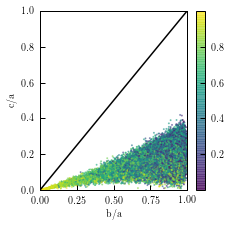

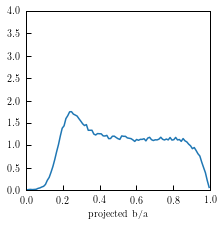

In [10]:
e = np.array(1-mock['galaxy_projected_b_to_a'])

plt.figure(figsize=(3.3,3.3))
plt.scatter(mock['galaxy_b_to_a'], mock['galaxy_c_to_a'], alpha=0.5, s=1, c=e)
plt.plot([0,1],[0,1], '-', color='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('b/a')
plt.ylabel('c/a')
plt.colorbar()
plt.show()

b_to_a = mock['galaxy_projected_b_to_a']

bins = np.linspace(0,1,100)
bin_centers = (bins[:-1]+bins[1:])/2.0
counts = np.histogram(b_to_a, bins=bins)[0]
counts = counts/np.sum(counts)/np.diff(bins)

plt.figure(figsize=(3.3,3.3))
plt.plot(bin_centers, counts)
plt.xlim([0,1])
plt.ylim([0,4])
plt.xlabel('projected b/a')
plt.show()